#Import the neccessary supporting files

In [ ]:
!wget https://til-ai.sbs/male.jpeg
!wget https://til-ai.sbs/man2.png
!wget https://til-ai.sbs/woman.jpeg
!wget https://til-ai.sbs/woman2.png

## Constrastive Loss

Epoch [1/20], Loss: 941.2230
Epoch [2/20], Loss: 824.9886
Epoch [3/20], Loss: 877.0312
Epoch [4/20], Loss: 716.5720
Epoch [5/20], Loss: 599.5549
Epoch [6/20], Loss: 580.3921
Epoch [7/20], Loss: 592.6583
Epoch [8/20], Loss: 535.3129
Epoch [9/20], Loss: 486.2705
Epoch [10/20], Loss: 382.6787
Epoch [11/20], Loss: 428.0458
Epoch [12/20], Loss: 410.3595
Epoch [13/20], Loss: 329.1720
Epoch [14/20], Loss: 349.9953
Epoch [15/20], Loss: 304.0505
Epoch [16/20], Loss: 332.4002
Epoch [17/20], Loss: 303.3569
Epoch [18/20], Loss: 315.6592
Epoch [19/20], Loss: 227.9644
Epoch [20/20], Loss: 232.2660


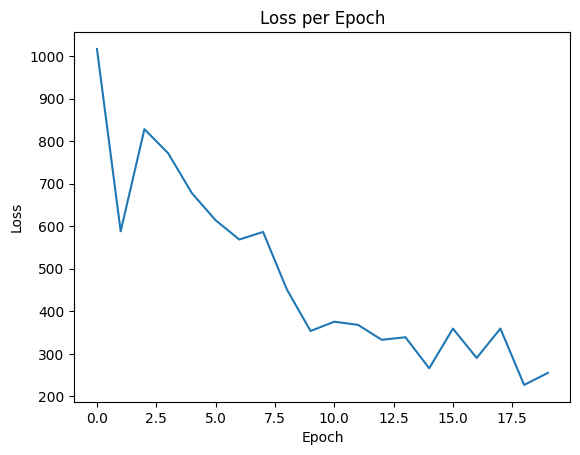

In [ ]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from pathlib import Path
from PIL import Image,  ImageDraw
import matplotlib.pyplot as plt

# Siamese Network definition
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.AdaptiveAvgPool2d((10, 10))  # Add this line
        )
        self.fc = nn.Linear(10 * 10 * 64, 4096)
        
    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2

# Siamese Dataset class
class SiameseDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.dataset = ImageFolder(root)
        self.labels = np.unique(self.dataset.targets)
        self.label_to_indices = {label: np.where(np.array(self.dataset.targets) == label)[0]
                                 for label in self.labels}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img1, label1 = self.dataset[index]
        same_class = np.random.randint(0, 2)
        if same_class:
            siamese_label = 1
            index2 = np.random.choice(self.label_to_indices[label1])
        else:
            siamese_label = 0
            label2 = np.random.choice(np.delete(self.labels, label1))
            index2 = np.random.choice(self.label_to_indices[label2])

        img2, _ = self.dataset[index2]

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(siamese_label, dtype=torch.float32)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

def create_synthetic_dataset(path, num_images=50, img_size=(100, 100)):
    Path(path).mkdir(parents=True, exist_ok=True)
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    shapes = ['circle', 'rectangle', 'triangle', 'ellipse', 'pentagon']

    for label, shape in enumerate(shapes):
        class_path = os.path.join(path, str(label))
        Path(class_path).mkdir(parents=True, exist_ok=True)
        for i in range(num_images):
            img = Image.new('RGB', img_size, 'white')
            draw = ImageDraw.Draw(img)
            color = random.choice(colors)
            x1, y1, x2, y2 = random.randint(10, 30), random.randint(10, 30), random.randint(60, 80), random.randint(60, 80)
            angle = random.randint(0, 360)

            # Create the shape
            temp_img = Image.new('RGBA', img_size)
            temp_draw = ImageDraw.Draw(temp_img)
            if shape == 'circle':
                temp_draw.ellipse((x1, y1, x2, y2), fill=color)
            elif shape == 'rectangle':
                temp_draw.rectangle((x1, y1, x2, y2), fill=color)
            elif shape == 'triangle':
                temp_draw.polygon([(x1, y1), (x2, y1), ((x1 + x2) // 2, y2)], fill=color)
            elif shape == 'ellipse':
                temp_draw.ellipse((x1, y1, x2, y2), fill=color)
            elif shape == 'pentagon':
                temp_draw.polygon([(x1, y1), (x2, y1), (x2 + (x1 - x2) // 4, (3 * y2 - y1) // 2),
                                   ((x1 + x2) // 2, y2), (x1 - (x2 - x1) // 4, (3 * y2 - y1) // 2)], fill=color)

            # Rotate the shape
            rotated_img = temp_img.rotate(angle, resample=Image.BICUBIC, expand=False)
            img.paste(rotated_img, (0, 0), rotated_img)

            img_path = os.path.join(class_path, f"{i}.png")
            img.save(img_path)

# Create synthetic dataset
dataset_path = "synthetic_data"
create_synthetic_dataset(dataset_path)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset and dataloader
root = dataset_path
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = SiameseDataset(root, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize the Siamese Network, loss function, and optimizer
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

num_epochs = 20
losses_per_epoch = []

for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    for batch_idx, (img1, img2, label) in enumerate(dataloader):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    epoch_avg_loss = epoch_loss / num_batches
    losses_per_epoch.append(loss.item())
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_avg_loss:.4f}")

# Plot the losses per batch
plt.plot(losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.show()


In [ ]:
# Create a synthetic test dataset
test_dataset_path = "synthetic_test_data"
create_synthetic_dataset(test_dataset_path, num_images=20)  # 20 images per class

# Define the test dataset and dataloader
test_dataset = SiameseDataset(test_dataset_path, transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Test the model and compute accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for img1, img2, label in test_dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        output1, output2 = model(img1, img2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        predictions = (euclidean_distance < 1).float()
        correct += (predictions == label).sum().item()
        total += label.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 59.00%


## Triplet Loss

Epoch [1/20], Loss: 3.7247
Epoch [2/20], Loss: 3.1318
Epoch [3/20], Loss: 2.3255
Epoch [4/20], Loss: 2.2885
Epoch [5/20], Loss: 2.1572
Epoch [6/20], Loss: 2.1252
Epoch [7/20], Loss: 1.7098
Epoch [8/20], Loss: 1.6854
Epoch [9/20], Loss: 1.8760
Epoch [10/20], Loss: 1.4402
Epoch [11/20], Loss: 1.2435
Epoch [12/20], Loss: 1.3757
Epoch [13/20], Loss: 1.1515
Epoch [14/20], Loss: 1.2250
Epoch [15/20], Loss: 1.1659
Epoch [16/20], Loss: 1.0806
Epoch [17/20], Loss: 1.2233
Epoch [18/20], Loss: 0.8945
Epoch [19/20], Loss: 1.2014
Epoch [20/20], Loss: 0.8864


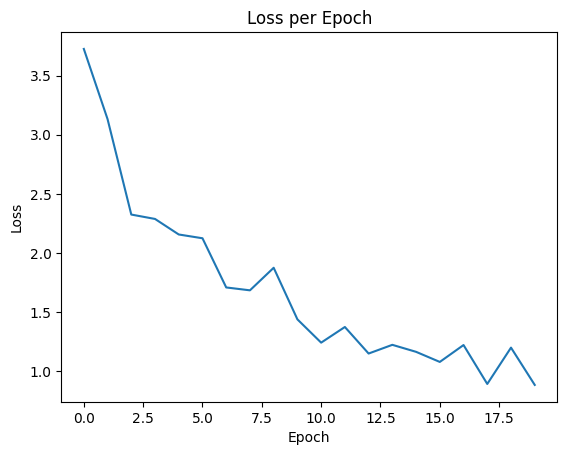

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torch.nn.functional as F
import os
import numpy as np
from pathlib import Path
import random
from PIL import ImageDraw
import matplotlib.pyplot as plt

# Siamese Network definition
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d((10, 10))
        )
        self.fc = nn.Linear(10 * 10 * 64, 4096)

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2, x3):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        output3 = self.forward_once(x3)
        return output1, output2, output3

# Triplet Loss
class TripletLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

def create_synthetic_dataset(path, num_images=50, img_size=(100, 100)):
    Path(path).mkdir(parents=True, exist_ok=True)
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    shapes = ['circle', 'rectangle', 'triangle', 'ellipse', 'pentagon']

    for label, shape in enumerate(shapes):
        class_path = os.path.join(path, str(label))
        Path(class_path).mkdir(parents=True, exist_ok=True)
        for i in range(num_images):
            img = Image.new('RGB', img_size, 'white')
            draw = ImageDraw.Draw(img)
            color = random.choice(colors)
            x1, y1, x2, y2 = random.randint(10, 30), random.randint(10, 30), random.randint(60, 80), random.randint(60, 80)
            angle = random.randint(0, 360)

            # Create the shape
            temp_img = Image.new('RGBA', img_size)
            temp_draw = ImageDraw.Draw(temp_img)
            if shape == 'circle':
                temp_draw.ellipse((x1, y1, x2, y2), fill=color)
            elif shape == 'rectangle':
                temp_draw.rectangle((x1, y1, x2, y2), fill=color)
            elif shape == 'triangle':
                temp_draw.polygon([(x1, y1), (x2, y1), ((x1 + x2) // 2, y2)], fill=color)
            elif shape == 'ellipse':
                temp_draw.ellipse((x1, y1, x2, y2), fill=color)
            elif shape == 'pentagon':
                temp_draw.polygon([(x1, y1), (x2, y1), (x2 + (x1 - x2) // 4, (3 * y2 - y1) // 2),
                                   ((x1 + x2) // 2, y2), (x1 - (x2 - x1) // 4, (3 * y2 - y1) // 2)], fill=color)

            # Rotate the shape
            rotated_img = temp_img.rotate(angle, resample=Image.BICUBIC, expand=False)
            img.paste(rotated_img, (0, 0), rotated_img)

            img_path = os.path.join(class_path, f"{i}.png")
            img.save(img_path)

class SiameseDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.dataset = ImageFolder(root)
        self.labels = np.unique(self.dataset.targets)
        self.label_to_indices = {label: np.where(np.array(self.dataset.targets) == label)[0]
                                 for label in self.labels}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        anchor, label1 = self.dataset[index]
        index_positive = np.random.choice(self.label_to_indices[label1])
        positive, _ = self.dataset[index_positive]

        label_negative = np.random.choice(np.delete(self.labels, label1))
        index_negative = np.random.choice(self.label_to_indices[label_negative])
        negative, _ = self.dataset[index_negative]

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

# Create synthetic dataset
dataset_path = "synthetic_data"
create_synthetic_dataset(dataset_path)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset and dataloader
root = dataset_path
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SiameseDataset(root, transform)
dataloader = DataLoader(dataset, batch_size=64 , shuffle=True)

# Initialize the Siamese Network, loss function, and optimizer
model = SiameseNetwork().to(device)
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Train the model
num_epochs = 20
losses_per_epoch = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (anchor, positive, negative) in enumerate(dataloader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()
        output1, output2, output3 = model(anchor, positive, negative)  # Change this line
        loss = criterion(output1, output2, output3)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= len(dataloader)
    losses_per_epoch.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Plot the loss per epoch
plt.plot(losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.show()



In [ ]:
# Create a synthetic test dataset
test_dataset_path = "synthetic_test_data"
create_synthetic_dataset(test_dataset_path, num_images=20)  # 20 images per class

# Define the test dataset and dataloader
test_dataset = SiameseDataset(test_dataset_path, transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Test the model and compute accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for anchor, positive, negative in test_dataloader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        output_anchor, output_positive, output_negative = model(anchor, positive, negative)
        euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
        euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
        predictions = (euclidean_distance_positive < euclidean_distance_negative).float()
        correct += predictions.sum().item()
        total += anchor.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 74.00%
